EE675A: Assignment 3 

Part 1: SARSA  (Deadline: 26th March 2023)

Part 2: Q-Learning  (Deadline: 30th March 2023)




# Cliff Walking 

Through this gridworld exercise we will compare Sarsa and Q-learning algorithms, highlighting the difference between them. Consider the gridworld shown in the Figure below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is −1 on all transitions except those into the the region marked “The Cliff.” Stepping into this region incurs a reward of −100 and sends the agent instantly back to the start.

There are totally 48 states numbered from 0 to 47

<img src='cliff_walking.png' width="600" align="left"></img> 



In [92]:
# Imports
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
from collections import defaultdict
matplotlib.style.use('ggplot')

# The environment class is already created for you. You have to just import it as follows.
from cliff_walking import CliffWalkingEnv



In [93]:
# Create environment
env = CliffWalkingEnv()

env.render()  
# Render is to see where we are in the environment
# "x" represents our current position in the grid
# "C" represents a cliff cell
# "T" is the target (Goal) cell
# "o" all the other cells


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [94]:
env.step(0)

(24, -1.0, False, {'prob': 1.0})

In [95]:
# Allowed Actions
# 0 => UP
# 1 => Right
# 2 => Down
# 3 => Left


# Let us take a few actions and get familiar with the environment
print('We started here')
env.reset()
env.render()

# Let us take up first
print('Let us take UP action')
env.step(0)
env.render()

# Now lets take another UP
print('Another UP action')
env.step(0)
env.render()

# Now lets take two rights
print('Two Right actions')
env.step(1)
env.step(1)
env.render()

# Now one left
print('One Left action')
env.step(3)
env.render()

We started here
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Let us take UP action
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Another UP action
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Two Right actions
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

One Left action
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [96]:
# A helper function for plotting the comparision graphs between two or more algorithms. 
# You need not understand this code.
# Just look at the next cell to understand how to use it.


def plot_episode_reward(a, stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    for stat in stats:
        rewards_smoothed = pd.Series(stat).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.legend(a)
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

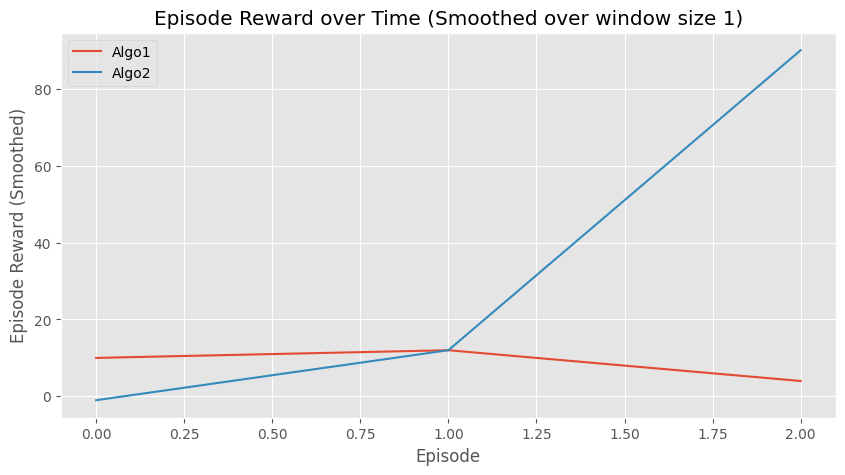

In [97]:
#Demo for using Plotting helper function
#Here we are comparing two algorithms which were run for 3 episodes each. 

stats_algo1= [10,12,4]    #The return obtained in each episode for Algo1
stats_algo2= [-1,12,90]    #The return obtained in each episode for Algo2

#Plotting the comparision
#Here the last argument is to smoothen the plot. Use higher values such as 10 for smooth plots.

plot_episode_reward(['Algo1','Algo2'],[stats_algo1,stats_algo2],smoothing_window=1)  

### Epsilon-greedy policy from Q-function and epsilon

Helper function to create epsilon-greedy policy based on a given Q-function and epsilon.

In [98]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the state/observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [99]:
# How to use make_epsilon-greedy_policy function
# consider two states s1, s2 and 3 actions {0,1,2} in each state

Q={'s1':[0.5, 2, 3], 's2':[-0.1, 4 , 3]}  # A sample Q-function Q(s,a) for each state-action pair

# For this example it is clear that for state s1, action 2 is the greedy action.
# For state s2, action 1 is the greedy action

"""
If we want an epsilon greedy policy with epsilon=0.3, then the best action
should get a probility = 0.7 + 0.3/3 = 0.8
other action with probability = 0.3/3 = 0.1

"""

# Let us verify this using our make_epsilon-greedy_policy function

policy_fn = make_epsilon_greedy_policy(Q, epsilon=0.3, nA=3)

print("The epsilon-greedy policy at state s1 is ", policy_fn('s1'))
print("The epsilon-greedy policy at state s2 is ", policy_fn('s2'))

The epsilon-greedy policy at state s1 is  [0.1 0.1 0.8]
The epsilon-greedy policy at state s2 is  [0.1 0.8 0.1]


## 1. SARSA algorithm

Implement the SARSA update to find the optimal action value function **[10 Marks]**

In [100]:
import random

def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a numpy array that stores the returns obtained in each episode
        For example, if we have run for 2 episodes and the returns obtained are -10, -25,
        stats=[-10,-25]

    """
    
    #Write your code here...#
    Q = np.zeros((env.nS, env.nA)) # initialize action-value function
    
    reward = 0
    stats = []
    
    for episodes in range(num_episodes): # for each episode
        t = 0
        state1 = env.reset()
            
        policy_fn = make_epsilon_greedy_policy(Q, epsilon, env.nA)
        
        action1 = random.choices((np.arange(env.nA)), policy_fn(state1), k = 1)[0] 
    
        cummu_reward = 0
        while t < 1000:
            # env.render()
            state2, reward, done, _ = env.step(action1)
            
            policy_fn = make_epsilon_greedy_policy(Q, epsilon, env.nA)
            action2 = random.choices((np.arange(env.nA)), policy_fn(state2), k = 1)[0] 

            # updating Q
            Q[state1][action1] = Q[state1][action1] + alpha * (reward + discount_factor * Q[state2][action2] - Q[state1][action1])
            
            state1 = state2
            action1 = action2
            
            t += 1
            cummu_reward = reward + discount_factor * cummu_reward
            
            
            if done:
                break
        
        stats.append(cummu_reward)
    
    #Write your code here...#
    
    return Q, stats

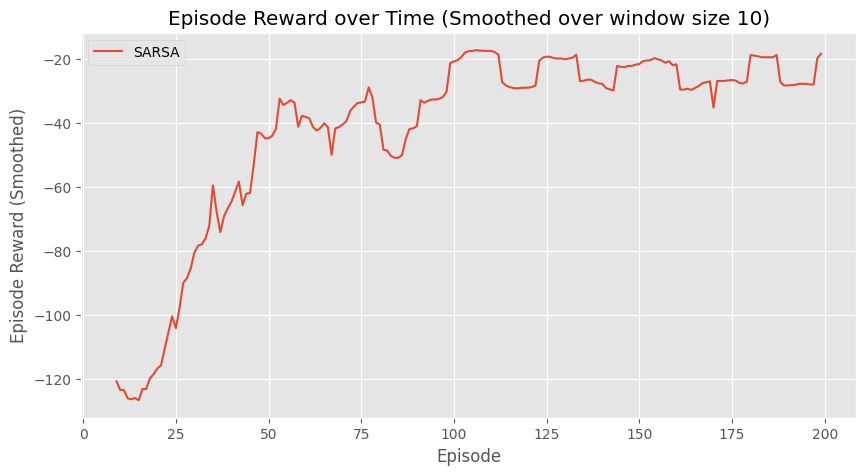

In [101]:
episodes = 200
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.1)
plot_episode_reward(['SARSA'],[stats_sarsa])

In [102]:
pi_sarsa = np.zeros(env.observation_space.n)
# pi_q = np.zeros(env.observation_space.n)
for s in range(env.observation_space.n):
    pi_sarsa[s] = np.argmax(Q_sarsa[s])
    # pi_q[s] = np.argmax(Q_q[s])
    
pi_sarsa = np.reshape(pi_sarsa, env.shape)
# pi_q = np.reshape(pi_q, env.shape)
# print(pi_sarsa)

print('SARSA policy:')
env.render_policy(pi_sarsa)
# print('Q-learning policy:')
# env.render_policy(pi_q)

SARSA policy:
→  →  →  →  →  →  →  →  →  ↓  ↓  ↓
→  ↑  ←  →  →  ↑  →  →  →  →  →  ↓
↑  ↑  ←  ←  ←  ↑  ↑  →  ↑  ↑  →  ↓
↑  C  C  C  C  C  C  C  C  C  C  T



## 2. Q-Learning algorithm

Implement the Q-Learning update to find the optimal action value function **[10 Marks]**

In [103]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a numpy array that stores the return obtained in each episode
    """
    
    #Write your code here...#
    
    
    #Write your code here...#
     
    return Q, stats

### Running and Generating Plots

In [104]:
episodes = 200
Q_q, stats_q, rollout_stats_q = q_learning(env, episodes, epsilon=0.1)
Q_sarsa, stats_sarsa = sarsa(env, episodes, epsilon=0.1)
plot_episode_reward(['Q-Learning','SARSA'],[stats_q, stats_sarsa])

NameError: name 'stats' is not defined

### Visualizing the policy

In [ ]:
# extracting greedy policy from the Q function
pi_sarsa = np.zeros(env.observation_space.n)
pi_q = np.zeros(env.observation_space.n)
for s in range(env.observation_space.n):
    pi_sarsa[s] = np.argmax(Q_sarsa[s])
    pi_q[s] = np.argmax(Q_q[s])
    
pi_sarsa = np.reshape(pi_sarsa, env.shape)
pi_q = np.reshape(pi_q, env.shape)
# print(pi_sarsa)

print('SARSA policy:')
env.render_policy(pi_sarsa)
print('Q-learning policy:')
env.render_policy(pi_q)